In [49]:
# import the neccessary dependacies we will use by default
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


Some insights into this project:
- The category of machine learning models that these fall into is _supervised learning_. Supervised learning is a type of machine learning where the model is trained on labeled data. The label in this case is the method of data breach.

The models that will be tested out will fall into the following category of machine learning:
* <u><b>Logistic Regression</b></u>: This is a supervised Learning that can be used to predict a categorical outcome. In this case, the categorical outcome is the method of the data breach. The features that will be used are: entity, year, records and organization type.
* <u><b>Decision Trees</b></u>: This is another supervised learning algorithm that can be used to predict a categorical outcome. Decision trees work by creating a tree-like structure that represents the relationships between the features and the outcomes.
* <u><b>Support Vector Machine(SVMs):</u></b> This is a supervised learning algorithm that can be used to predict both categorical and continous outcomes. SVMs work by finding the hyperplane that best seperates the data points into different classes.
* <u><b>Random Forests</u></b> This is an ensemble learning algorithm that combines multiple decision trees to improve the accuracy of the predictions.
* <u><b>Neural Networks</u></b> This is a more complex algorithm that can be used to predict both categorical and continuous outcomes. Neural Networks work by learning the relationships between the features and the outcome through a process called backpropogation.

In [50]:
# load the dataset(s) we will be using
csv_file_path = os.path.abspath('df_1.csv');  # get the absolute path of the CS

df = pd.read_csv(csv_file_path);   # Read the CSV file into a datafram
# display the head to see if the dataset works as intended
df.head(10)  #adjust the parameter value as needed

,Unnamed: 0,Entity,Year,Records,Organization type,Method,Sources
0,0,21st Century Oncology,2016,2200000,healthcare,hacked,[5][6]
1,1,500px,2020,14870304,social networking,hacked,[7]
2,2,Accendo Insurance Co.,2020,175350,healthcare,poor security,[8][9]
3,3,Adobe Systems Incorporated,2013,152000000,tech,hacked,[10]
4,4,Adobe Inc.,2019,7500000,tech,poor security,[11][12]
5,5,Advocate Medical Group,2017,4000000,healthcare,lost / stolen media,[13][14]
6,6,AerServ (subsidiary of InMobi),2018,75000,advertising,hacked,[15]
7,7,"Affinity Health Plan, Inc.",2013,344579,healthcare,lost / stolen media,[16][17]
8,8,Airtel,2019,320000000,telecommunications,poor security,[18]
9,9,Air Canada,2018,20000,transport,hacked,[19]


From my exploration, I discovered that dataframe 3 and dataframe 1 are the same, so merging them would be useless, dataframe 2 is different from dataframe 1, therefore, merging them holds some value.

In [51]:
df.dtypes  # simply lists out the datatype we are working with

Unnamed: 0            int64
Entity               object
Year                 object
Records              object
Organization type    object
Method               object
Sources              object
dtype: object

In [52]:
df.columns # observe the column list

Index(['Unnamed: 0', 'Entity', 'Year', 'Records', 'Organization type',
       'Method', 'Sources'],
      dtype='object')

In [53]:
# we will need to rename the unnamed column
df.rename(columns={'Unnamed: 0' : 'Index'}, inplace=True)

In [54]:
# Test out the number of unique values contained in Entity
len(df['Entity'].unique())   #there's a total of 331 unique name for comapnies

331

Regarding the column __Entity__, there's 2 options in terms of data preprocessing:
* Drop the column altogether
* Apply Hashing

In [55]:
import hashlib

#create a hash function
def hash_function(text):
    return hashlib.sha256(text.encode()).hexdigest()

# create a new column for the hashed values
df['hashed_Entity'] = df['Entity'].apply(hash_function)

#observe the hashed column
df.head()  # we have the hashed entity

,Index,Entity,Year,Records,Organization type,Method,Sources,hashed_Entity
0,0,21st Century Oncology,2016,2200000,healthcare,hacked,[5][6],c3a872f67b2c21449ed696e019d008cbb15b384ed63164...
1,1,500px,2020,14870304,social networking,hacked,[7],39b1d7f5c52ecec4511c7d93214a3dc33915fcb67c51e1...
2,2,Accendo Insurance Co.,2020,175350,healthcare,poor security,[8][9],d37b82c7c3fef3eb56a05bc88697bd64c489f8b13b9ed8...
3,3,Adobe Systems Incorporated,2013,152000000,tech,hacked,[10],4ea8e5179ec6c6866f040ebfa23a41946cb05bd37b5ebc...
4,4,Adobe Inc.,2019,7500000,tech,poor security,[11][12],4e2eb72d6ffd4a841309dcd87b646d2408ac7394956117...


In [56]:
# create a copy of the dataframe and drop the Entity column 
df_copy1 = df.drop(columns={'Entity'})

In [57]:
df_copy1  # we don't want to make modifications to the original dataframe 

,Index,Year,Records,Organization type,Method,Sources,hashed_Entity
0,0,2016,2200000,healthcare,hacked,[5][6],c3a872f67b2c21449ed696e019d008cbb15b384ed63164...
1,1,2020,14870304,social networking,hacked,[7],39b1d7f5c52ecec4511c7d93214a3dc33915fcb67c51e1...
2,2,2020,175350,healthcare,poor security,[8][9],d37b82c7c3fef3eb56a05bc88697bd64c489f8b13b9ed8...
3,3,2013,152000000,tech,hacked,[10],4ea8e5179ec6c6866f040ebfa23a41946cb05bd37b5ebc...
4,4,2019,7500000,tech,poor security,[11][12],4e2eb72d6ffd4a841309dcd87b646d2408ac7394956117...
...,...,...,...,...,...,...,...
347,347,2019,173000000,social network,hacked,[406][407],637e6be11e5f556343bad0073ff64ddcf396a88cec35d7...
348,348,2020,200000000,financial,accidentally published,[408],985ee128022c38982d1de4c4173f538ced9151f0517fe9...
349,349,2020,391250,healthcare,poor security,[409],869ada24f3639cb94ed2dd22ec15aca5928cb7b7c0bc28...
350,350,2022,6400000,various,poor security,[410] [411],89def538702db6ab06b39b1d28f5f7980de01dd04bd0a0...


In [58]:
len(df_copy1['Organization type'].unique())   # in terms of organization type, there's 70 different unique values
df_copy1

,Index,Year,Records,Organization type,Method,Sources,hashed_Entity
0,0,2016,2200000,healthcare,hacked,[5][6],c3a872f67b2c21449ed696e019d008cbb15b384ed63164...
1,1,2020,14870304,social networking,hacked,[7],39b1d7f5c52ecec4511c7d93214a3dc33915fcb67c51e1...
2,2,2020,175350,healthcare,poor security,[8][9],d37b82c7c3fef3eb56a05bc88697bd64c489f8b13b9ed8...
3,3,2013,152000000,tech,hacked,[10],4ea8e5179ec6c6866f040ebfa23a41946cb05bd37b5ebc...
4,4,2019,7500000,tech,poor security,[11][12],4e2eb72d6ffd4a841309dcd87b646d2408ac7394956117...
...,...,...,...,...,...,...,...
347,347,2019,173000000,social network,hacked,[406][407],637e6be11e5f556343bad0073ff64ddcf396a88cec35d7...
348,348,2020,200000000,financial,accidentally published,[408],985ee128022c38982d1de4c4173f538ced9151f0517fe9...
349,349,2020,391250,healthcare,poor security,[409],869ada24f3639cb94ed2dd22ec15aca5928cb7b7c0bc28...
350,350,2022,6400000,various,poor security,[410] [411],89def538702db6ab06b39b1d28f5f7980de01dd04bd0a0...


In [59]:
# remove the special characters
df_copy1['Organization type'] = df_copy1['Organization type'].str.replace(',', '_')  # replace the cases of ',' with '_'.
df_copy1['Organization type'] = df_copy1['Organization type'].str.replace(' ', '_') # we also replace the cases of spacing with '_'.
df_copy1['Organization type'] = df_copy1['Organization type'].str.replace('__', '_')  # replace all instances of __ with _

Before encoding the organization type, I've copied the df to keep the original data intact. I'm dropping the hashed_Entity column as it is not needed for visualizing – we want to focus on industries and not individual companies.

In [60]:
df_vis = df_copy1  #create another copy of the df_copy and perform further data preprocessing
#drop the hashed entity column
df_vis.drop(columns={'hashed_Entity'}, inplace=True)  #note: after dropping the column the first time, you may end up running into an error if you were to rerun the code block again
#drop the Sources column
df_vis.drop(columns={'Sources'}, inplace=True)
df_vis

,Index,Year,Records,Organization type,Method
0,0,2016,2200000,healthcare,hacked
1,1,2020,14870304,social_networking,hacked
2,2,2020,175350,healthcare,poor security
3,3,2013,152000000,tech,hacked
4,4,2019,7500000,tech,poor security
...,...,...,...,...,...
347,347,2019,173000000,social_network,hacked
348,348,2020,200000000,financial,accidentally published
349,349,2020,391250,healthcare,poor security
350,350,2022,6400000,various,poor security


In [61]:
# Initialize a list to store index positions and non-integer values as tuples
non_integer_records = []

# Initialize a set to store unique industries
unique_industries = set()

# Iterate through the 'Records' column and collect non-integer values with their index positions and industry
for index, (value, industry) in enumerate(zip(df_vis['Records'], df_vis['Organization type'])):
    try:
        int_value = int(value)
    except ValueError:
        non_integer_records.append((index, str(value), industry))
        unique_industries.add(industry)

# Print the index positions, values, and industries for non-integer values
if non_integer_records:
    print("Non-integer values in the 'Records' column:")
    print("Index, Value, Industry")
    for index, value, industry in non_integer_records:
        print(index, value, industry)
else:
    print("No non-integer values in the 'Records' column.")
    
# Print the list of unique industries from non-integer records
if unique_industries:
    print("Unique industries from non-integer records:")
    print(list(unique_industries))
else:
    print("No unique industries found in non-integer records.")

Non-integer values in the 'Records' column:
Index, Value, Industry
10 unknown web
25 unknown dating
27 G20 world leaders government
28 19 years of data academic
34 63 stores retail
40 nan gaming
41 unknown gambling
47 tens of thousands retail
48 over 5,000,000 government
66 unknown (client list) information_technology
76 millions retail
80 235 GB military
82 350 clients emails consulting_accounting
94 9,000,000 (approx) - basic booking, 2208 (credit card details) transport
104 unknown financial
109 unknown tech
119 Unknown Information_Security
134 unknown web
140 unknown healthcare
142 2.5GB transport
147 250 locations hotel
163 unknown mobile_carrier
168 500 locations restaurant
175 10 locations hotel
185 unknown software
198 unknown financial
199 93 stores retail
215 unknown telecom
220 unknown government
221 undisclosed web
232 unknown web
235 unknown hotel
243 unknown tech
248 Source Code Compromised Network_Monitoring
251 100 terabytes media
260 54 locations hotel
265 200 stores r

In [62]:
updated_non_integer_records = []
# types = list()

for industry in unique_industries:
    # Create a separate DataFrame for the current industry
    industry_df = df_vis[df_vis['Organization type'] == industry]
    
    # Drop entries with non-integer values in 'Records'
    industry_df['Records'] = pd.to_numeric(industry_df['Records'], errors='coerce')
    industry_df = industry_df.dropna()
    
    # Calculate the mean records for the current industry
    mean_records = industry_df['Records'].mean()
    
    # #add the type of mean_records to the types list
    # types.append(type(mean_records))
    
    # Update 'Records' in the original DataFrame if mean is not NaN and remove from non_integer_records
    #if the mean_record is nan, its type will be float
    if type(mean_records) != float:
        # Print the mean records for the current industry
        # print(f"Industry: {industry}, Type: {type(mean_records)}, Mean Records: {mean_records}")
        for index, value, industry_name in non_integer_records:
            if industry_name == industry:
                df_vis.at[index, 'Records'] = mean_records
    else:
        updated_non_integer_records.append(industry)

#make the types list a set
# types = set(types)
# print(f"Types of mean_records: {types}")
print(f"Updated non-integer records: {updated_non_integer_records}")

Updated non-integer records: ['information_technology', 'software', 'dating', 'consulting_accounting', 'Information_Security', 'web_service', 'gambling', 'Network_Monitoring', 'arts_group']


/var/folders/sk/r_8fkf9s2ys9d8p1lfwj100r0000gn/T/ipykernel_22372/819895320.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  industry_df['Records'] = pd.to_numeric(industry_df['Records'], errors='coerce')


In [65]:
# Calculate the mean records value for the entire DataFrame df_vis (excluding non-numeric values)
df_vis['Records'] = pd.to_numeric(df_vis['Records'], errors='coerce')
df_vis = df_vis.dropna()
mean_records_all = df_vis['Records'].mean()

# Replace 'Records' values in updated_non_integer_records with the mean records for the entire DataFrame
for industry in updated_non_integer_records:
    # for each entry in the dataframe, if the industry matches the industry in the updated_non_integer_records, replace the value with the mean_records_all
    for index, value, industry_name in non_integer_records:
        if industry_name == industry:
            df_vis.at[index, 'Records'] = mean_records_all
print(df_vis)
#Check that there are no more non-integer values in 'Records'
non_integer_records = []
for index, value, industry in zip(df_vis.index, df_vis['Records'], df_vis['Organization type']):
    try:
        int_value = int(value)
    except ValueError:
        non_integer_records.append((index, str(value), industry))

if non_integer_records:
    print("Non-integer values in the 'Records' column:")
    print("Index, Value, Industry")
    for index, value, industry in non_integer_records:
        print(index, value, industry)
else:
    print("No remaining non-integer values in the 'Records' column!")

#Update all the values in the Records column to be integers
df_vis['Records'] = df_vis['Records'].astype(int)

# Check the data types of the DataFrame in the 'Records' column
print(df_vis.dtypes)
print(df_vis)

     Index  Year    Records  Organization type                  Method
0      0.0  2016    2200000         healthcare                  hacked
1      1.0  2020   14870304  social_networking                  hacked
2      2.0  2020     175350         healthcare           poor security
3      3.0  2013  152000000               tech                  hacked
4      4.0  2019    7500000               tech           poor security
..     ...   ...        ...                ...                     ...
347  347.0  2019  173000000     social_network                  hacked
348  348.0  2020  200000000          financial  accidentally published
349  349.0  2020     391250         healthcare           poor security
350  350.0  2022    6400000            various           poor security
351  351.0  2022      95000             retail  accidentally published

[342 rows x 5 columns]
No remaining non-integer values in the 'Records' column!
Index                float64
Year                  object
Records  

Checking if the Year column is well formatted (should be a year like 2016, or 2019, not 2016-2019). If not, we'll need to do some data cleaning.

In [66]:
#Check if any value in the year column is null
print("Null values: ", df_vis['Year'].isnull().values.any())  # there are no null values in the year column

#Check if any value in the year column is not well formatted (i.e. not a number)
print("Non numeric values: ", df_vis['Year'].str.isnumeric().values.any())  # there are values that are not numeric

#print out all the values in the year column that are not numeric
print(df_vis[~df_vis['Year'].str.isnumeric()])  # as we can see, the three columns that have non-numeric values are in index 94 96 and 144



Null values:  False
Non numeric values:  True
     Index           Year   Records Organization type  Method
94    94.0      2019-2020  13394400         transport  hacked
96    96.0      2018-2019   2000000        restaurant  hacked
144  144.0  2014 and 2015    363000             hotel  hacked


In [67]:
#drop the index column
df_vis.drop(columns={'Index'}, inplace=True)
#observe the dataset to see if the column index has been successfully dropped
print(df_vis)  

     Year    Records  Organization type                  Method
0    2016    2200000         healthcare                  hacked
1    2020   14870304  social_networking                  hacked
2    2020     175350         healthcare           poor security
3    2013  152000000               tech                  hacked
4    2019    7500000               tech           poor security
..    ...        ...                ...                     ...
347  2019  173000000     social_network                  hacked
348  2020  200000000          financial  accidentally published
349  2020     391250         healthcare           poor security
350  2022    6400000            various           poor security
351  2022      95000             retail  accidentally published

[342 rows x 4 columns]


There are 3 values in the Year column that are not well formed – we also will need to fix the Records column for similar formatting issues.

In [68]:
'''
Modify df_vis:
for each value in the year column that is not numeric:
    record the last year listed in the year column (i.e. the last 4 characters)
    record the first year listed in the year column (i.e. the first 4 characters)
change the year column of this entry to the first 4 characters (the first year)
for each year between the first year and the last year:
    add a new entry to the dataframe with the same values as the entry that was changed, except for the year column, which will be the year in question
'''
last_row_index = df_vis.tail(1).index[0]
# Create an empty list to store modified rows
new_rows = []

# Iterate through the DataFrame
for index, row in df_vis.iterrows():
    year_value = row['Year']
    
    # Check if the year is not numeric
    if not year_value.isnumeric():
        # Extract the first and last year
        first_year = int(year_value[:4])
        last_year = int(year_value[-4:])
        
        # Calculate the range of years and ensure it's at least 1
        year_range = max(last_year - first_year, 0) + 1

        # Change the year column to the first year
        df_vis.loc[index, 'Year'] = str(first_year)
        
        # Calculate the records divided by the number of years in the range
        records_divided = row['Records'] / year_range
        
        # Update the records column with the new value
        df_vis.loc[index, 'Records'] = records_divided
        
        #Create new rows for each year between the first and last year
        for year in range(first_year + 1, last_year + 1):
            last_row_index+=1 # Increment the index of the last row
            new_row = row.copy()  # Create a copy of the current row
            new_row['Year'] = str(year)
            # new_row['Index'] = last_row_index
            new_row['Records'] = records_divided
            new_rows.append(new_row) # Append the new row to the list

# Concatenate the new rows with the original DataFrame
new_rows_df = pd.DataFrame(new_rows)

df_vis = pd.concat([df_vis, new_rows_df], ignore_index=True)

# Convert Records to int
df_vis['Records'] = df_vis['Records'].astype(int)

# convert the year column to int
df_vis['Year'] = df_vis['Year'].astype(int)


print(df_vis.dtypes)
print(df_vis)

Year                  int64
Records               int64
Organization type    object
Method               object
dtype: object
     Year    Records  Organization type                  Method
0    2016    2200000         healthcare                  hacked
1    2020   14870304  social_networking                  hacked
2    2020     175350         healthcare           poor security
3    2013  152000000               tech                  hacked
4    2019    7500000               tech           poor security
..    ...        ...                ...                     ...
340  2022    6400000            various           poor security
341  2022      95000             retail  accidentally published
342  2020    6697200          transport                  hacked
343  2019    1000000         restaurant                  hacked
344  2015     181500              hotel                  hacked

[345 rows x 4 columns]


In [69]:
#count the unique values in the organization column
print("Organizations: ", len(df_vis['Organization type'].unique()))  # there are 60 values in the organization column

#for each organization in the organization column, split the name on "_" and take the first word. Make a dictionary with the first word as the key and the number of times it appears as its valuee
organization_dict = {}
for organization in df_vis['Organization type'].unique():
    first_word = organization.split('_')[0]
    if first_word in organization_dict:
        organization_dict[first_word] += 1
    else:
        organization_dict[first_word] = 1
#for each key in the dictionary, if it appears more than once, print it out as well as the number of times it appears
for key in organization_dict:
    if organization_dict[key] > 1:
        print(key, organization_dict[key])


Organizations:  60
social 3
tech 3
web 4
financial 3
government 4
military 2
online 2


We should combine industries that are similar. For example, financial and financial services should be combined into one category.

In [70]:
# for each organization in the dictionary, if it appears more than once, replace the organization column with the first word of the organization
for index, row in df_vis.iterrows():
    organization = row['Organization type']
    first_word = organization.split('_')[0]
    if organization_dict[first_word] > 1:
        df_vis.loc[index, 'Organization type'] = first_word
# check how many unique values there are in the organization column
print("Unique Organizations: ", len(df_vis['Organization type'].unique()))

print(df_vis)

Unique Organizations:  46
     Year    Records Organization type                  Method
0    2016    2200000        healthcare                  hacked
1    2020   14870304            social                  hacked
2    2020     175350        healthcare           poor security
3    2013  152000000              tech                  hacked
4    2019    7500000              tech           poor security
..    ...        ...               ...                     ...
340  2022    6400000           various           poor security
341  2022      95000            retail  accidentally published
342  2020    6697200         transport                  hacked
343  2019    1000000        restaurant                  hacked
344  2015     181500             hotel                  hacked

[345 rows x 4 columns]


In [90]:
most_frequent_word = df_vis['Method'].value_counts().index[0]
#replace all occurences of "Unknown" with "Hacked"
df_vis['Method'].replace('unknown', most_frequent_word, inplace=True)

In [91]:
#check if there are any null values in each column
if df_vis.isnull().values.any():
    print("There are null values in the dataframe")
else:
    print("There are no null values in the dataframe")

print(df_vis.dtypes)

There are no null values in the dataframe
Year                  int64
Records               int64
Organization type     int64
Method               object
dtype: object


In [92]:
#print the lowest and highest year
print("Lowest Year: ", df_vis['Year'].min())
print("Highest Year: ", df_vis['Year'].max())

# print the lowest and highest records
print("Lowest Records: ", df_vis['Records'].min())
print("Highest Records: ", df_vis['Records'].max())
print()

#print the top 3 organizations with the highest records
print(df_vis.groupby('Organization type')['Records'].sum().sort_values(ascending=False).head(3))
print()

#print the total records for the healthcare industry
print("Total records lost in the healthcare industry: ")
print(df_vis[df_vis['Organization type'] == 'healthcare']['Records'].sum())

Lowest Year:  2004
Highest Year:  2022
Lowest Records:  6700
Highest Records:  3000000000

Organization type
45    5665351000
13    1912193697
38    1392928802
Name: Records, dtype: int64

Total records lost in the healthcare industry: 
0


Data Visualization

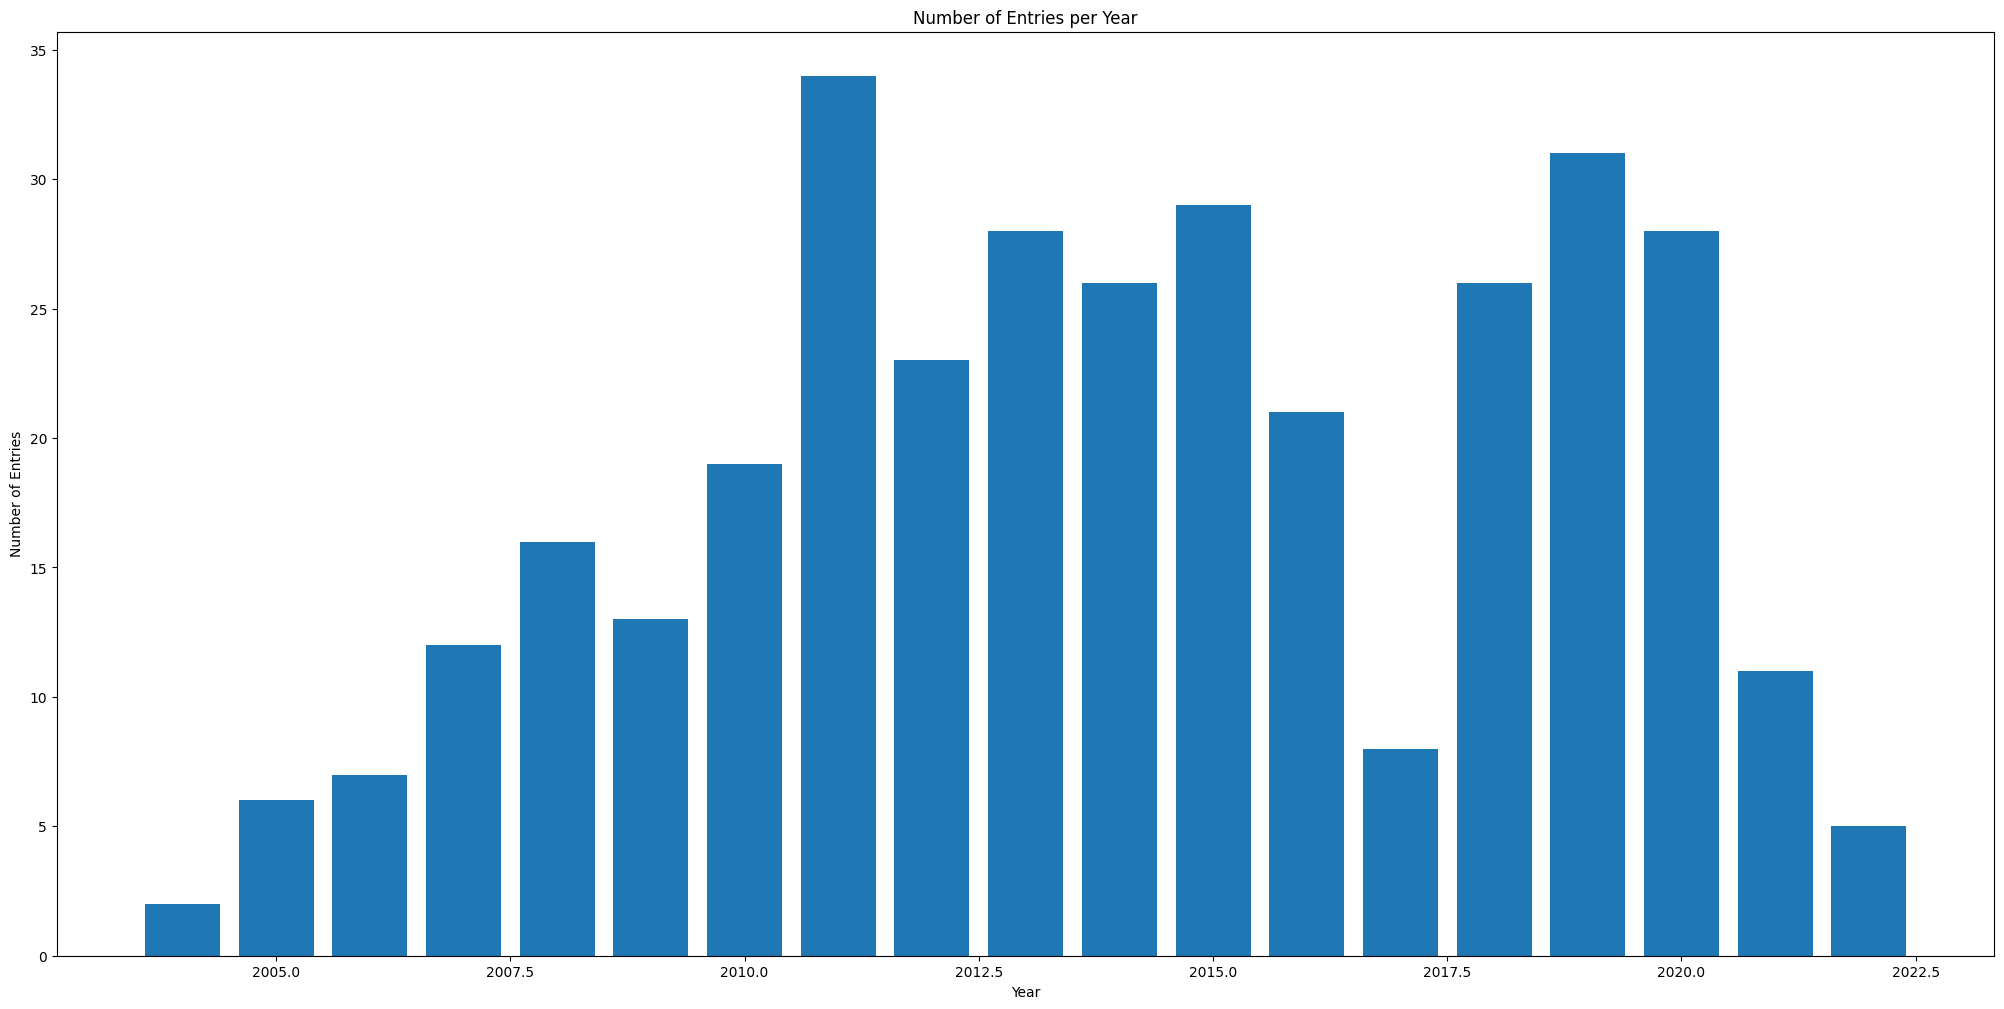

In [73]:
# Grouping the data by year
grouped_data = df_vis.groupby('Year').size()

# Sorting the grouped data by year
grouped_data = grouped_data.sort_index()

# Creating a bar plot with figsize
fig, ax = plt.subplots(figsize=(25, 12))
ax.bar(grouped_data.index, grouped_data.values)

# Adding labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Number of Entries')
ax.set_title('Number of Entries per Year')

# Display the plot
plt.show()


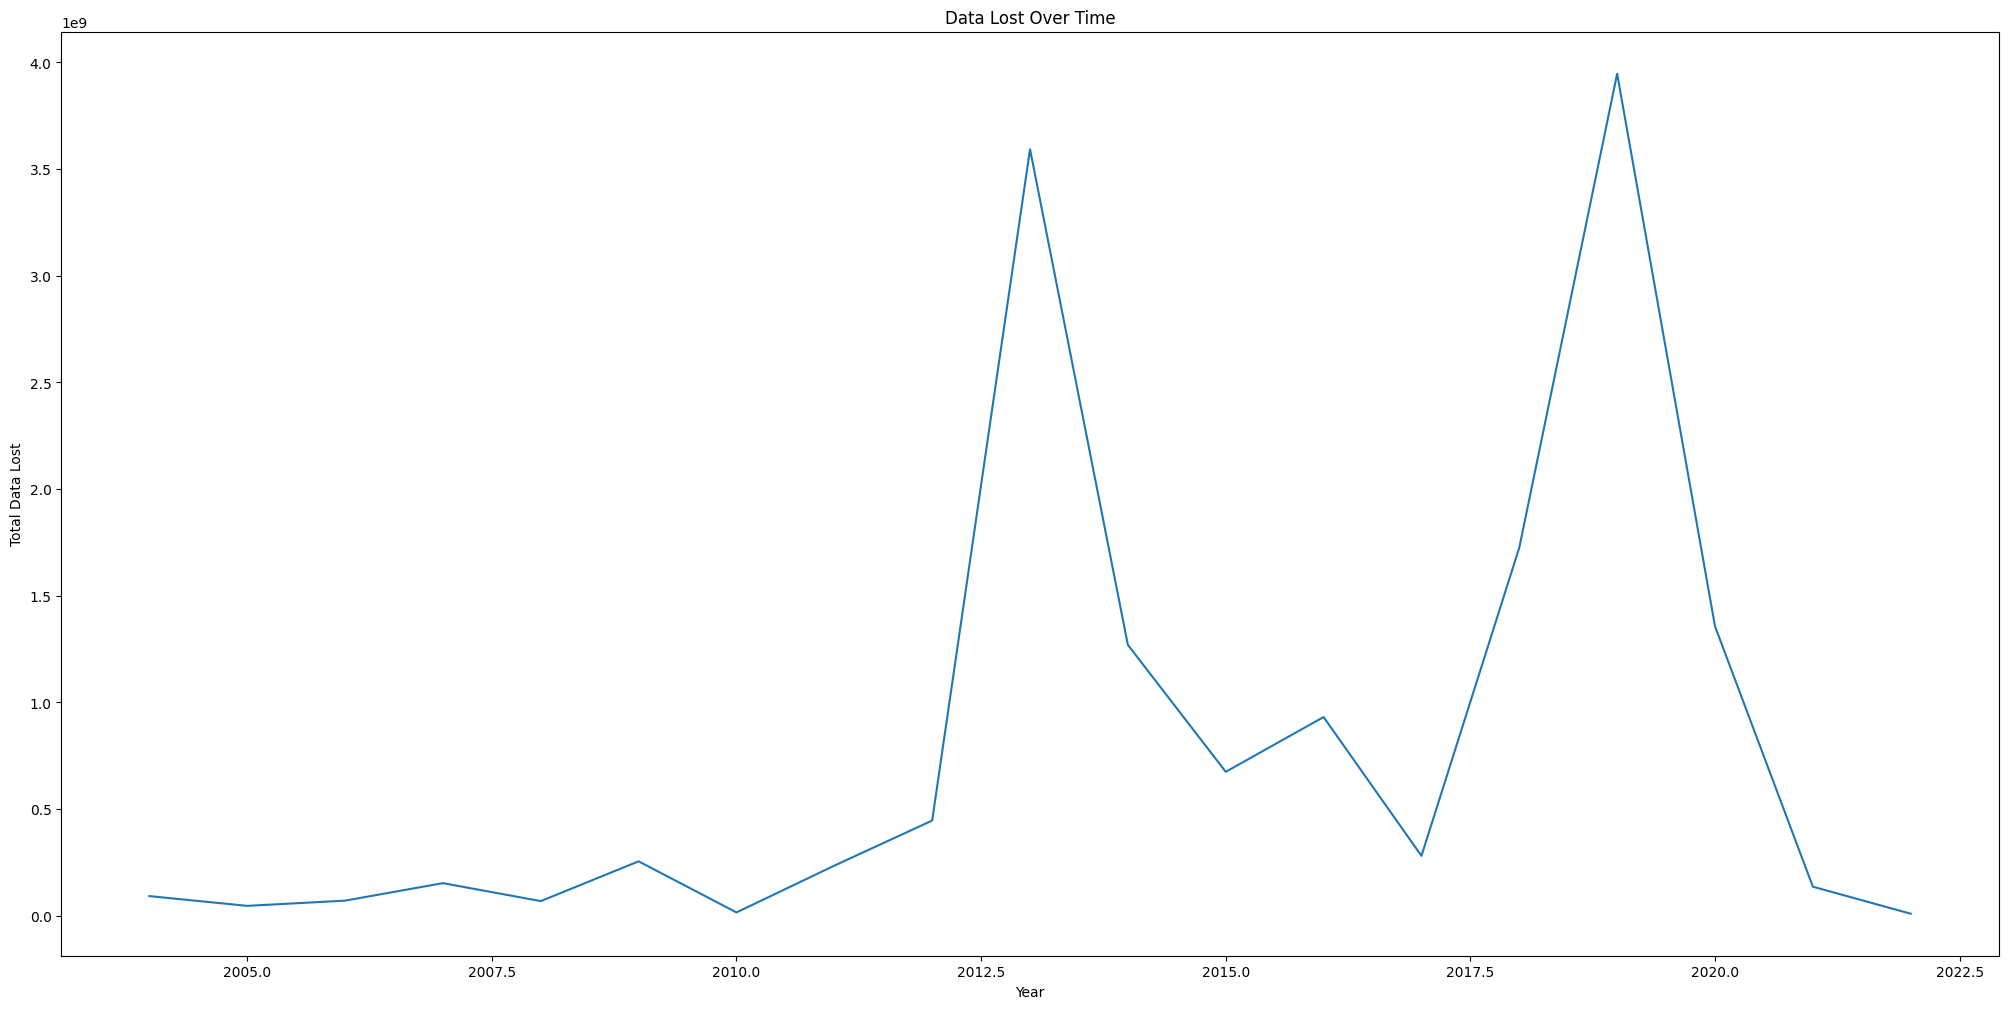

In [74]:
# Group the data by year and sum the records for each year
data_lost_over_time = df_vis.groupby('Year')['Records'].sum()

# Create a line plot for data lost over time
data_lost_over_time.plot(kind='line', figsize=(25, 12))
plt.title("Data Lost Over Time")
plt.xlabel("Year")
plt.ylabel("Total Data Lost")
plt.show()

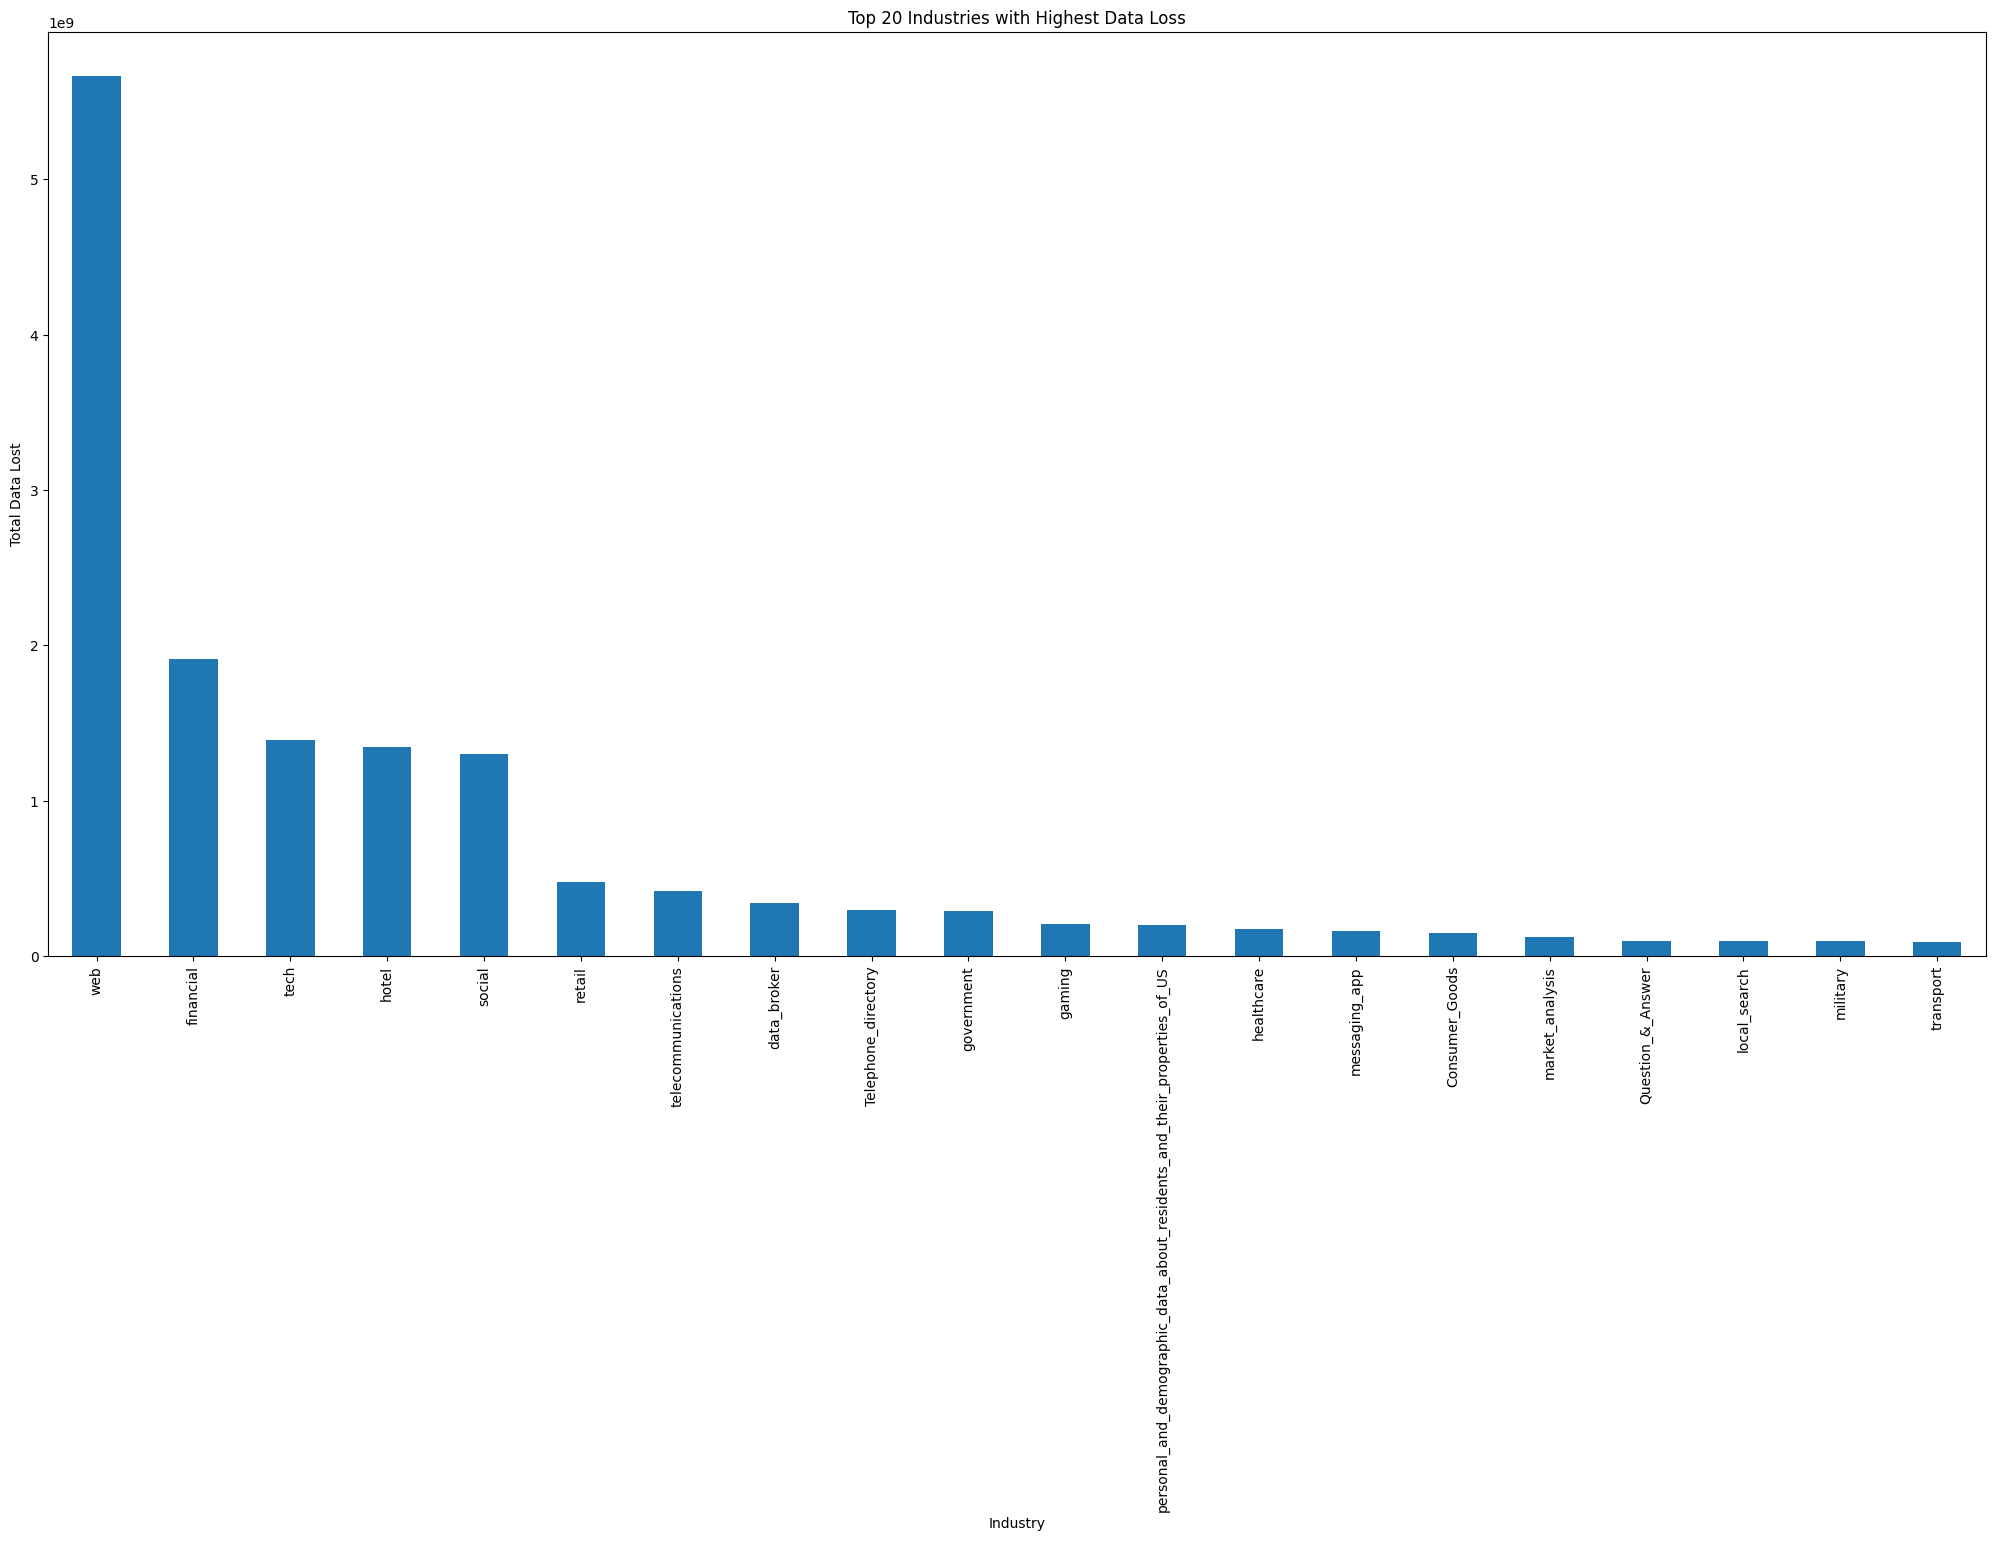

In [75]:
# Group the data by industry and sum the records for each industry, then select the top 20 industries
top_20_industries = df_vis.groupby('Organization type')['Records'].sum().nlargest(20)

# Create a bar plot for the top 10 industries with the highest data loss
top_20_industries.plot(kind='bar', figsize=(25, 12))
plt.title("Top 20 Industries with Highest Data Loss")
plt.xlabel("Industry")
plt.ylabel("Total Data Lost")
plt.xticks(rotation=90)
plt.show()

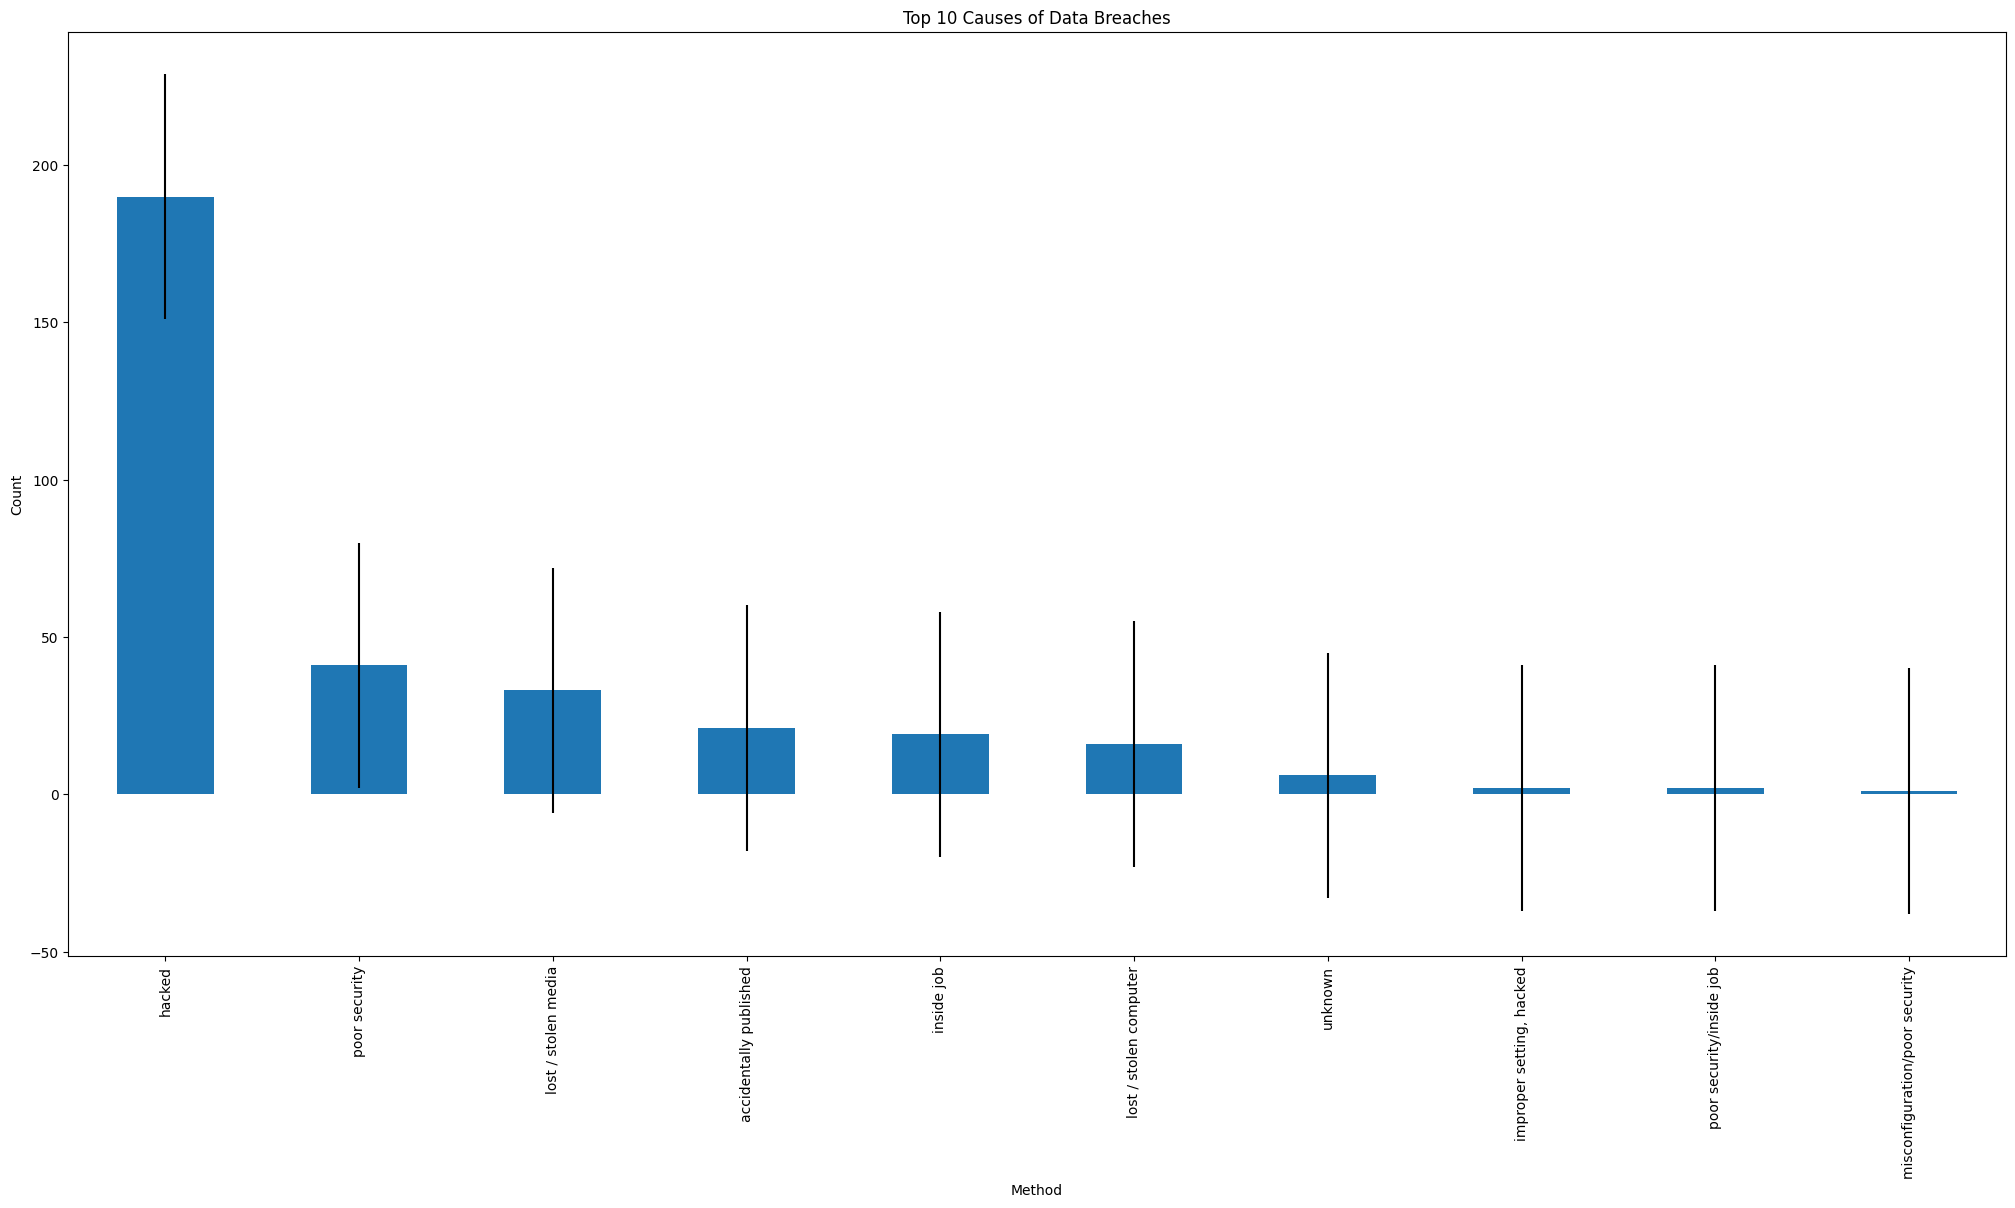

In [76]:
# Group the data by the method and count the occurrences, then select the top 10 causes
top_10_causes = df_vis['Method'].value_counts().nlargest(10)

# Create a bar plot for the top 10 causes of data breaches
top_10_causes.plot(kind='bar', figsize=(25, 12))
plt.title("Top 10 Causes of Data Breaches")
plt.xlabel("Cause")
plt.ylabel("Count")
plt.xticks(rotation=90)
top_10_causes.plot(kind='bar', figsize=(25, 12), yerr=df_vis['Method'].value_counts().std())
plt.show()


when we calculate the error bars, theres an upper and lower bound, the upper bound is the mean + the standard deviation, the lower bound is the mean - the standard deviation.
So, drawing a line through the lower bound, and it doesnt touch the other line, that means that the difference is statistically significant.

We may want to exclude the data that is statistically significant, because it may be an outlier.

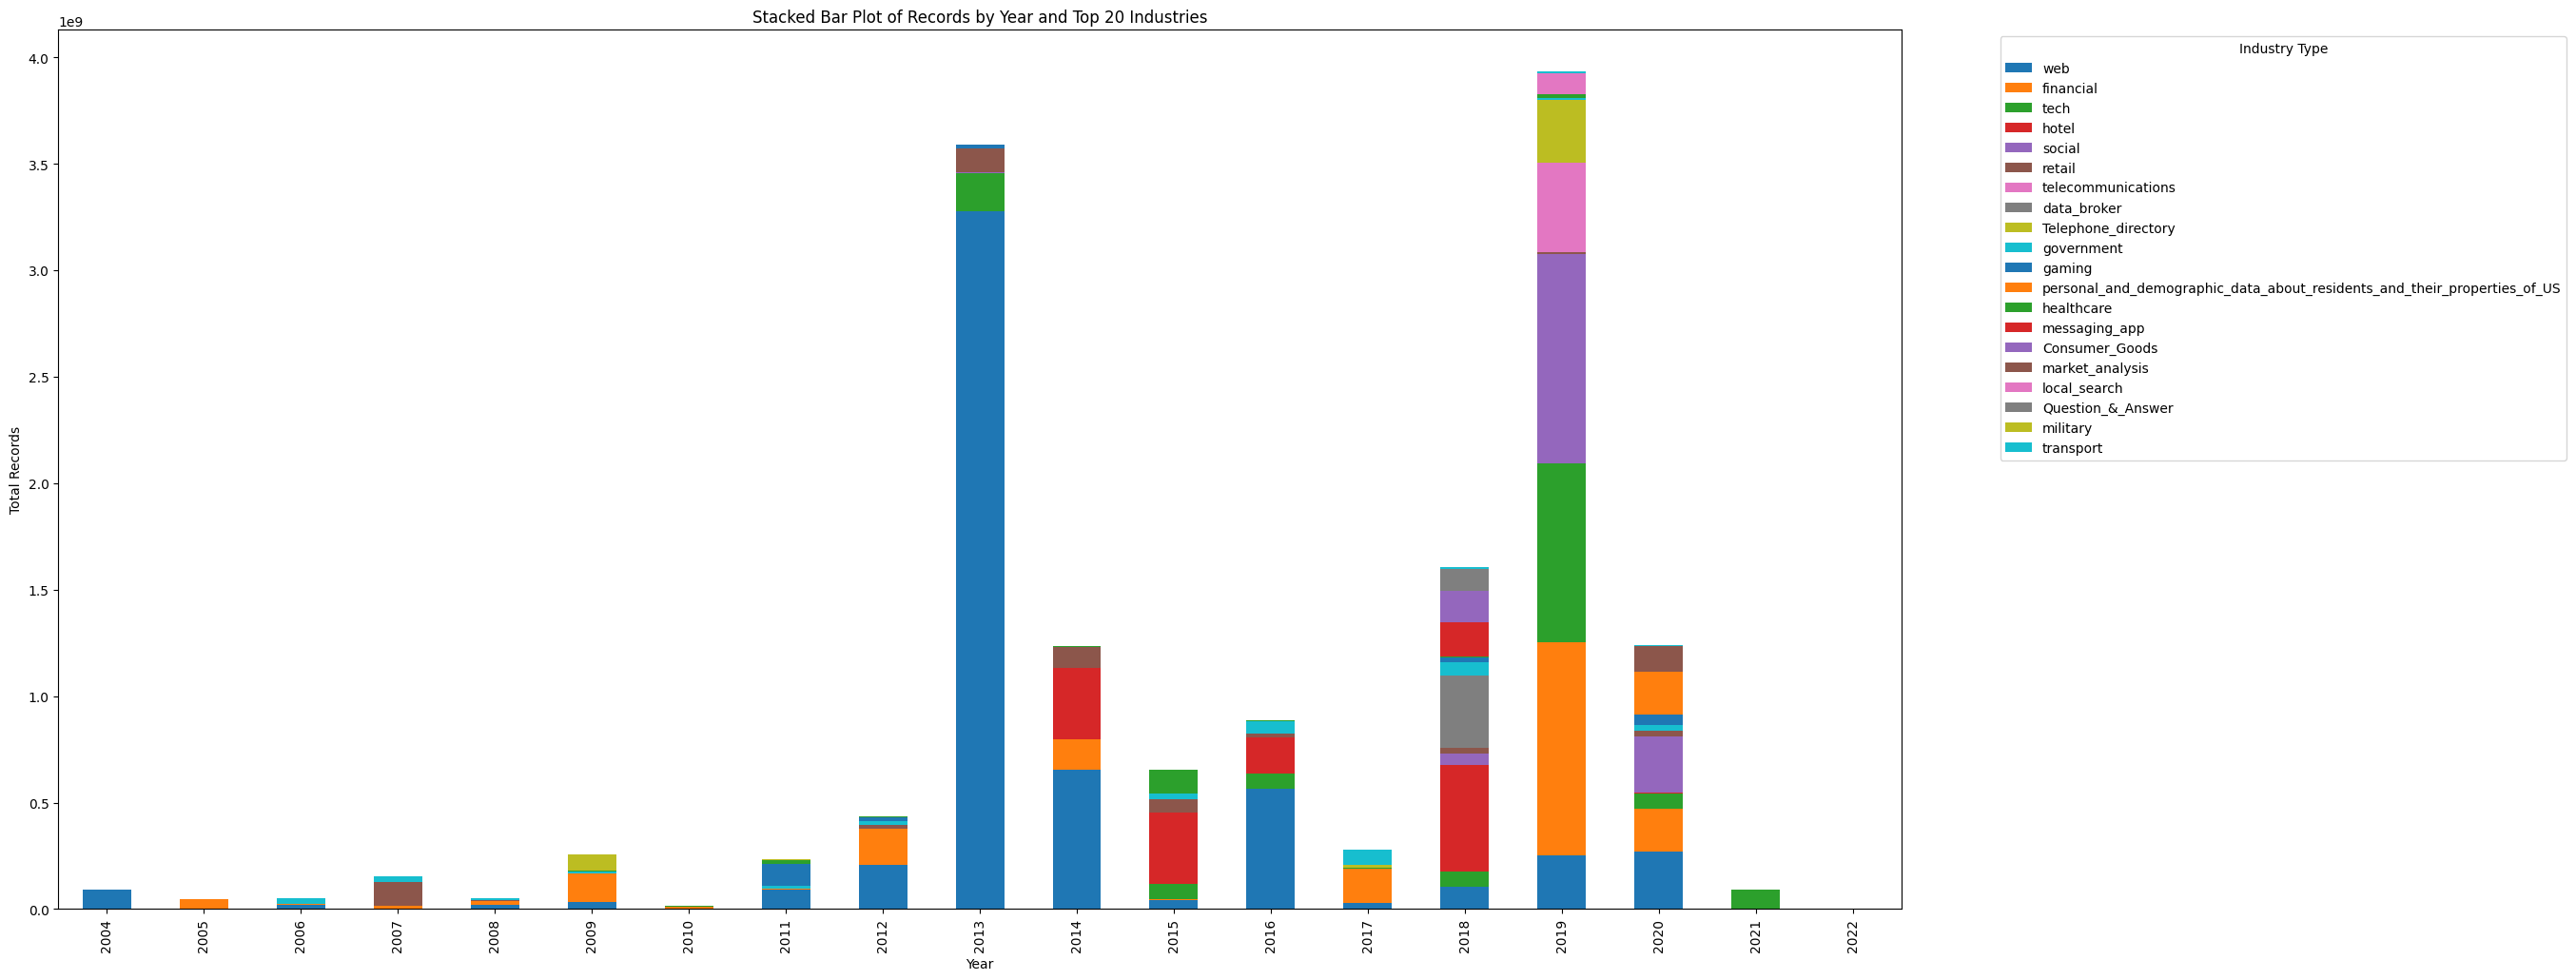

In [77]:
# Grouping the data by year and industry and summing the 'Records' column
records_by_year_and_industry = df_vis.groupby(['Year', 'Organization type'])['Records'].sum().unstack()

# Finding the top 20 industries based on total records
top_20_industries = records_by_year_and_industry.sum().sort_values(ascending=False).head(20).index

# Filtering the DataFrame to include only the top 20 industries
records_by_year_and_industry_top20 = records_by_year_and_industry[top_20_industries]

# Creating a stacked bar plot for records by year and industry (top 20)
records_by_year_and_industry_top20.plot(kind='bar', stacked=True, figsize=(25, 12))

# Adding labels and title
plt.title("Stacked Bar Plot of Records by Year and Top 20 Industries")
plt.xlabel("Year")
plt.ylabel("Total Records")
plt.xticks(rotation=90)
plt.legend(title='Industry Type', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position

# Display the plot
plt.show()

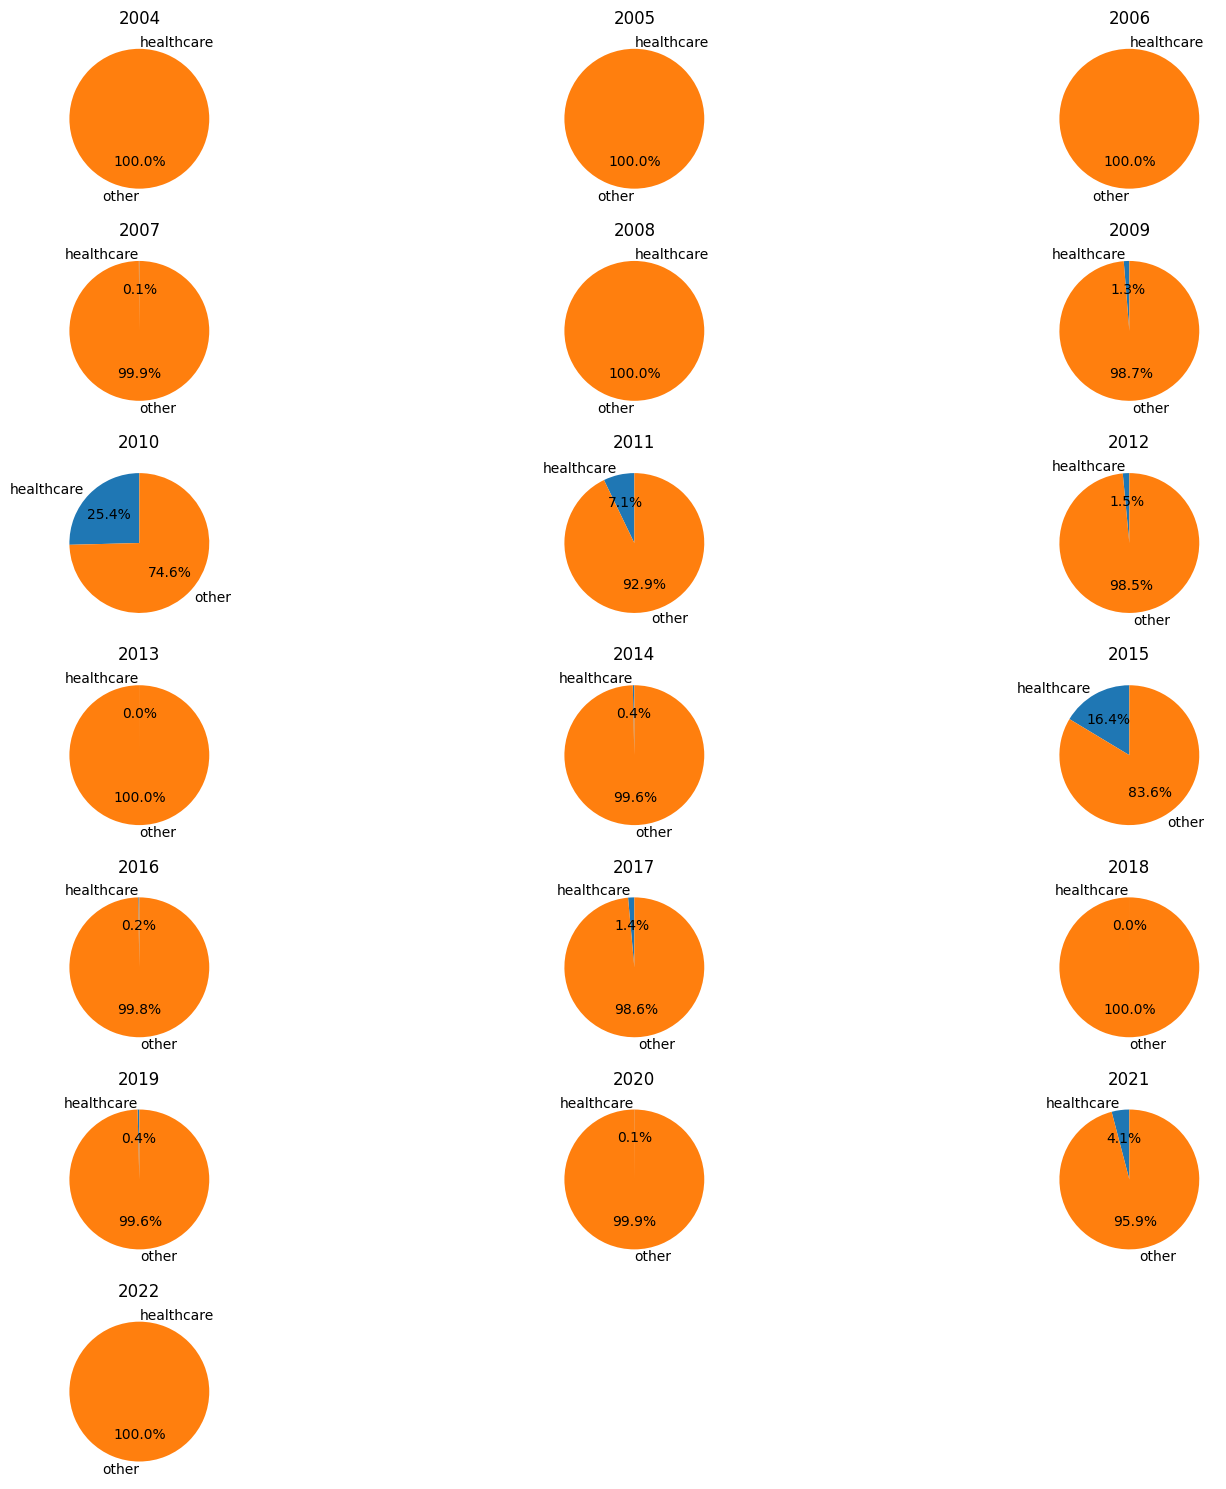

In [78]:
# Grouping the data by year and industry and summing the 'Records' column
records_by_year_and_industry = df_vis.groupby(['Year', 'Organization type'])['Records'].sum().unstack()

# Finding the top 20 industries based on total records
top_20_industries = records_by_year_and_industry.sum().sort_values(ascending=False).head(13).index

# Filtering the DataFrame to include all industries and filling NaN values with 0
records_by_year_and_industry_all = records_by_year_and_industry.fillna(0)

# Create a consolidated image for all pie charts
plt.figure(figsize=(15, 15))

# Create subplots based on the number of years
num_years = len(records_by_year_and_industry_all.index)
num_cols = 3  # Adjust the number of columns based on your preference
num_rows = (num_years + num_cols - 1) // num_cols

for i, year in enumerate(records_by_year_and_industry_all.index, start=1):
    data_for_year = records_by_year_and_industry_all.loc[year]

    # Calculate the percentage of records lost in the healthcare industry and the rest
    healthcare_percentage = data_for_year['healthcare'] / data_for_year.sum()
    other_percentage = 1 - healthcare_percentage

    # Create subplots
    plt.subplot(num_rows, num_cols, i)
    plt.pie([healthcare_percentage, other_percentage], labels=['healthcare', 'other'],
            autopct=lambda p: '{:.1f}%'.format(p) if p > 0 else '',
            startangle=90)
    plt.title(f"{year}")

# Adjust layout
plt.tight_layout()
plt.show()

In [79]:
print(df_vis)

     Year    Records Organization type                  Method
0    2016    2200000        healthcare                  hacked
1    2020   14870304            social                  hacked
2    2020     175350        healthcare           poor security
3    2013  152000000              tech                  hacked
4    2019    7500000              tech           poor security
..    ...        ...               ...                     ...
340  2022    6400000           various           poor security
341  2022      95000            retail  accidentally published
342  2020    6697200         transport                  hacked
343  2019    1000000        restaurant                  hacked
344  2015     181500             hotel                  hacked

[345 rows x 4 columns]


In [ ]:
# Perform one-hot encoding on 'Organization type' and 'Method'
df_encoded = df_vis.copy()
df_encoded = pd.get_dummies(df_vis, columns=['Organization type', 'Method'], prefix=['Org', 'Method'])

# Display the one-hot encoded DataFrame
print(df_encoded)

### Linear Regression to predict Records

In [ ]:
# X = df_encoded.drop(['Records'], axis=1)  # Features (excluding the target variable)
# y = df_encoded['Records']  # Target variable

# # Create a linear regression model
# model = LinearRegression()

# # Fit the model on the entire data
# model.fit(X, y)

# # Make predictions on the features
# y_pred = model.predict(X)

# # Add the predicted values to the DataFrame
# df_encoded['Predicted_Records'] = y_pred

# # Create a regression plot
# plt.figure(figsize=(12, 8))
# sns.regplot(x='Records', y='Predicted_Records', data=df_encoded, scatter_kws={'s': 10}, line_kws={'color': 'red'})
# plt.title('Regression Plot: Actual vs Predicted Records')
# plt.xlabel('Actual Records')
# plt.ylabel('Predicted Records')
# plt.show()

So, that's not a great performance. Let's try to handle outliers.

In [ ]:
# from scipy.stats.mstats import winsorize
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline

# df_encoded1 = df_vis.copy()

# # Extract features (X) and target variable (y)
# X = df_encoded1[['Organization type']]
# y = df_encoded1['Records']

# # One-hot encode the categorical variable 'Organization type'
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('org_type', OneHotEncoder(), ['Organization type'])
#     ])

# # Create a linear regression model
# model = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', LinearRegression())
# ])

# # Fit the model on the data
# model.fit(X, y)

# # Make predictions on the features
# y_pred = model.predict(X)

# # Add the predicted values to the DataFrame
# df_encoded1['Predicted_Records'] = y_pred

# # Create a regression plot
# plt.figure(figsize=(12, 8))
# sns.regplot(x='Records', y='Predicted_Records', data=df_encoded1, scatter_kws={'s': 10}, line_kws={'color': 'red'})
# plt.title('Regression Plot: Actual vs Predicted Records')
# plt.xlabel('Actual Records')
# plt.ylabel('Predicted Records')
# plt.show()

Not much better. Let's look at some clustering while we reconsider our approach.

In [ ]:
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt

# df_cluster = df_vis.copy()

# # Select features for clustering
# features = df_cluster[['Year', 'Records']]

# # Standardize the features (important for K-means)
# scaler = StandardScaler()
# features_scaled = scaler.fit_transform(features)

# # Choose the number of clusters 
# num_clusters = 2

# # Apply K-means clustering
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# df_cluster['Cluster'] = kmeans.fit_predict(features_scaled)

# # Visualize the clusters
# plt.scatter(df_cluster['Year'], df_cluster['Records'], c=df_cluster['Cluster'], cmap='viridis')
# plt.title('K-means Clustering')
# plt.xlabel('Year')
# plt.ylabel('Records')
# plt.show()

# # Create cross-tabulation for 'Organization type'
# organization_type_cross_tab = pd.crosstab(df_cluster['Cluster'], df_cluster['Organization type'], margins=True, margins_name='Total')

# # Create cross-tabulation for 'Method of hacking'
# method_of_hacking_cross_tab = pd.crosstab(df_cluster['Cluster'], df_cluster['Method'], margins=True, margins_name='Total')

# # Plot heatmaps
# plt.figure(figsize=(14, 6))
# plt.subplot(1, 2, 1)
# sns.heatmap(organization_type_cross_tab, annot=True, cmap='coolwarm', fmt='d')
# plt.title('Organization Type Cross-Tabulation')

# plt.subplot(1, 2, 2)
# sns.heatmap(method_of_hacking_cross_tab, annot=True, cmap='coolwarm', fmt='d')
# plt.title('Method of Hacking Cross-Tabulation')

# plt.show()

## Label Encoding

In [80]:
le = LabelEncoder()  #perform label encoding on the organization_type, the copy of df_vis

# implement label encoding on the Organization type column
le.fit(df_vis['Organization type'])   # fit the data we want to train the encoder on
df_vis['Organization type'] = le.transform(df_vis['Organization type'])
# observe how the column 'Organization Type' has changed
df_vis.head()

,Year,Records,Organization type,Method
0,2016,2200000,19,hacked
1,2020,14870304,36,hacked
2,2020,175350,19,poor security
3,2013,152000000,38,hacked
4,2019,7500000,38,poor security


In [81]:
df_vis.dtypes   # as we can see, the Organization type changed from Object --> integer datatype

Year                  int64
Records               int64
Organization type     int64
Method               object
dtype: object

In [82]:
# observe the label frequency, to gain an understanding of outliers and inlier values
df_vis['Organization type'].value_counts()

Organization type
45    56
19    47
13    40
17    35
34    27
38    22
5     13
15    12
41    12
36    11
21     9
27     8
43     8
11     4
33     4
25     3
29     2
39     2
28     2
40     2
3      1
0      1
12     1
31     1
32     1
2      1
42     1
4      1
16     1
1      1
24     1
9      1
23     1
35     1
37     1
22     1
30     1
26     1
18     1
20     1
7      1
14     1
8      1
10     1
6      1
44     1
Name: count, dtype: int64

In [83]:
df_vis['Method']  # we will also need to perform label encoding on the method section

0                      hacked
1                      hacked
2               poor security
3                      hacked
4               poor security
                ...          
340             poor security
341    accidentally published
342                    hacked
343                    hacked
344                    hacked
Name: Method, Length: 345, dtype: object

In [84]:
df_vis['Method'].unique()

array(['hacked', 'poor security', 'lost / stolen media',
       'accidentally published', 'inside job, hacked',
       'lost / stolen computer', 'unsecured S3 bucket', 'unknown',
       'inside job', 'accidentally uploaded', 'poor security / hacked',
       'Poor security', 'unprotected api', 'poor security/inside job',
       'data exposed by misconfiguration', 'intentionally lost',
       'misconfiguration/poor security', 'ransomware hacked',
       'rogue contractor', 'improper setting, hacked',
       'hacked/misconfiguration',
       'publicly accessible Amazon Web Services (AWS) server',
       'accidentally exposed', 'social engineering'], dtype=object)

In [ ]:
""# seems like the method column contains certain NaN values and certain Unknown values, we will need to determine whether we replace such values or drop them in its entirety
df_vis['Method'].value_counts()     

In [85]:
#check which columns have null/unknoown values
null_mask = df_vis.isnull().any(axis=1)
null_rows=df_vis[null_mask]

print(null_rows)

Empty DataFrame
Columns: [Year, Records, Organization type, Method]
Index: []


In [86]:
df_vis.isnull().all()   

Year                 False
Records              False
Organization type    False
Method               False
dtype: bool

In [88]:
most_frequent_word = df_vis['Method'].value_counts().index[0]
#replace all occurences of "Unknown" with "Hacked"
df_vis['Method'].replace('unknown', most_frequent_word, inplace=True)

In [93]:
print(list(df_vis['Method'].unique()))   # based on the list, we can see that the Method column doesn't contain unknown anymore.
print(len(list(df_vis['Method'].value_counts())) )

['hacked', 'poor security', 'lost / stolen media', 'accidentally published', 'inside job, hacked', 'lost / stolen computer', 'unsecured S3 bucket', 'inside job', 'accidentally uploaded', 'poor security / hacked', 'Poor security', 'unprotected api', 'poor security/inside job', 'data exposed by misconfiguration', 'intentionally lost', 'misconfiguration/poor security', 'ransomware hacked', 'rogue contractor', 'improper setting, hacked', 'hacked/misconfiguration', 'publicly accessible Amazon Web Services (AWS) server', 'accidentally exposed', 'social engineering']
23


In [94]:
# prior to implementing label encoding, we will need to clear up the string of some grammatical issues that will cause mismatched data when we train the model otherwise
# we want uniformity for the data input values
# convert all uppercase letters to lowercase
df_vis['Method'] = df_vis['Method'].str.lower()

# replace all spaces with "_"
df_vis['Method'] = df_vis['Method'].str.replace(' ', '_')

# replace all slash signs with "_"
df_vis['Method'] = df_vis['Method'].str.replace('/', '_')

# replace all __ and ___ with _
df_vis['Method'] = df_vis['Method'].str.replace('___', '_')
df_vis['Method'] = df_vis['Method'].str.replace('__', '_')

# check the updated dataframe
list(df_vis['Method'].unique())

['hacked',
 'poor_security',
 'lost_stolen_media',
 'accidentally_published',
 'inside_job,_hacked',
 'lost_stolen_computer',
 'unsecured_s3_bucket',
 'inside_job',
 'accidentally_uploaded',
 'poor_security_hacked',
 'unprotected_api',
 'poor_security_inside_job',
 'data_exposed_by_misconfiguration',
 'intentionally_lost',
 'misconfiguration_poor_security',
 'ransomware_hacked',
 'rogue_contractor',
 'improper_setting,_hacked',
 'hacked_misconfiguration',
 'publicly_accessible_amazon_web_services_(aws)_server',
 'accidentally_exposed',
 'social_engineering']

In [95]:
# now the method column is ready for label encoding preprocessing, since we already called on the label encoder previously, we can reuse it
le.fit(df_vis['Method'])  # train the label encoder on the column data we want to train
df_vis['Method'] = le.transform(df_vis['Method'])

In [96]:
df_vis.dtypes 

Year                 int64
Records              int64
Organization type    int64
Method               int64
dtype: object

### READY TO TRAIN